In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 1. Load dataset
data = pd.read_csv('/content/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

In [3]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# 2. Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# 3. Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
# 4. Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
# 5. Training loop
epochs = 100
for epoch in range(epochs):
    for seq, target in dataloader:
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10/100, Loss: 0.0035
Epoch 20/100, Loss: 0.0014
Epoch 30/100, Loss: 0.0039
Epoch 40/100, Loss: 0.0014
Epoch 50/100, Loss: 0.0041
Epoch 60/100, Loss: 0.0046
Epoch 70/100, Loss: 0.0034
Epoch 80/100, Loss: 0.0036
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0034


In [8]:
# 6. Predict
model.eval()
predictions = model(X_tensor).detach().numpy()
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_tensor.reshape(-1, 1))

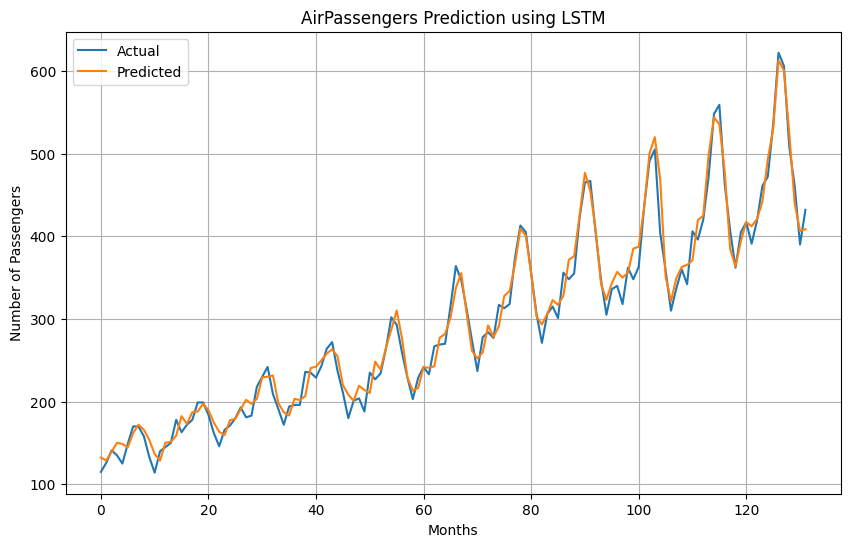

In [9]:
# 7. Plot
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('AirPassengers Prediction using LSTM')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()